# Monthly DFM

In this notebook, I test the capabilities of Chad Fulton's [code](https://github.com/ChadFulton/tsa-notebooks/blob/master/statespace_large_dynamic_factor_models.ipynb), which estimates a monthly dynamic factor model. I apply it to a German dataset consisting of 18 monthly economic indicators, 10 financial variables, 8 survey series, 10 topics, and one quarterly variable (GDP growth, consumption growth, or investment growth). The goal is to forecast the quarterly variable.

Here, I will only use 10 topics to forecast the quarterly variable.

In [1]:
%matplotlib inline

import types
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

- Load monthly (36 variables) and quarterly (1 variable) economic and financial indicators.
- Apply transformations to ensure stationarity of the data.

In [2]:
def transform(column, transforms):
    transformation = transforms[column.name]
    # For quarterly data like GDP, I will compute
    # annualized percent changes
    mult = 4 if column.index.freqstr[0] == 'Q' else 1
    
    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 3:
        column = np.log(column).diff() * 100 * mult
        
    return column

In [3]:
def load_data(vintage, q_var):
    
    # - Monthly data --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'../data/vintages_monthly/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # 3. Extract the date as an index
    orig_m.index = pd.PeriodIndex(orig_m.date.tolist(), freq='M')
    orig_m.drop('date', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m)

    # - Quarterly data --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'../data/vintages_quarterly/{vintage}.csv')
                .dropna(how='all'))
    # Keep the quarterly variable that will be forecasted
    orig_q = orig_q[['date', q_var]]

    # 2. Extract transformation information
    transform_q = orig_q.iloc[0, 1:]
    orig_q = orig_q.iloc[1:]

    # 3. Extract the date as an index
    orig_q.index = pd.PeriodIndex(orig_q.date.tolist(), freq='Q')
    orig_q.drop('date', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q)

    # - Output datasets ------------------------------------------------------
    return types.SimpleNamespace(
        orig_m=orig_m, orig_q=orig_q,
        dta_m=dta_m, transform_m=transform_m,
        dta_q=dta_q, transform_q=transform_q)

* Load seven vintages: 2008-01-01 (all data available up to 31 Dec 2007; forecast made on 1 Jan 2008), 2008-01-16, 2008-02-01, 2008-02-16, 2008-03-01, 2008-03-16, and 2008-04-01.

In [4]:
# Load the vintages of data
q_var = 'GDP'
dta = {date: load_data(date, q_var = q_var)
       for date in ['2008-01-01', '2008-01-16', '2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']}

In [5]:
# Print some information about the base dataset
n, k = dta['2008-01-01'].dta_m.shape
start = dta['2008-01-01'].dta_m.index[0]
end = dta['2008-01-01'].dta_m.index[-1]

print(f'For vintage 2008-01-01, there are {k} series and {n} observations,'
      f' over the period {start} to {end}.')

For vintage 2008-01-01, there are 36 series and 204 observations, over the period 1991-01 to 2007-12.


* Load text data

In [6]:
def load_text_data(vintage, q_var, text_type="topics", estimation_period="2007", num_topics="200", source = "all"):
    
    # 1. Download data
    filename = f'../data/vintages_monthly_{q_var}_{text_type}_{estimation_period}_{num_topics}_{source}/{vintage}.csv'
    orig_text = pd.read_csv(filename).dropna(how='all')
    
    # 2. Extract transformation information
    transform_text = orig_text.iloc[0, 1:]
    orig_text = orig_text.iloc[1:]
    
    # 3. Extract the date as an index
    orig_text.index = pd.PeriodIndex(orig_text.date.tolist(), freq='M')
    orig_text.drop('date', axis=1, inplace=True)
    
    # 4. Apply the transformations
    dta_text = orig_text.apply(transform, axis=0, transforms=transform_text)
    
     # - Output datasets 
    return types.SimpleNamespace(
        orig_text=orig_text, 
        dta_text=dta_text, 
        transform_text=transform_text)

In [7]:
# Parameters for the text file
text_type = "topics"           # could also be "topics_BPW" or "topics_uncertainty"
estimation_period = "2007"     # topics estimated on data <=2007, could also be "2018"
num_topics = "200"             # number of topics, could also be "100"
source = "all"                 # "all", "dpa", "hb", "sz", or "welt"
only_text = True

# Loop over each vintage and load the corresponding text data
for date in ['2008-01-01', '2008-01-16', '2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']:
    # Load text data for each vintage
    text_obj = load_text_data(date, q_var=q_var, 
                              text_type=text_type, 
                              estimation_period=estimation_period, 
                              num_topics=num_topics,
                              source = source)
    if only_text:
        dta[date].combined = text_obj.dta_text.copy()
    else:
        # Merge the monthly economic data (dta_m) with the text data
        dta[date].combined = dta[date].dta_m.merge(text_obj.dta_text, left_index=True, right_index=True, how='outer')

* Load definitions with full names of the variables and their groups (Activity, Labor market, Prices, Financial, Surveys, and Text)

In [8]:
# Load the definitions Excel file for monthly variables
defn_m = pd.read_excel('../data/data_monthly/variables_definitions.xlsx')
# Set the index to the "Mnemonic" column
defn_m.index = defn_m['Mnemonic']

# Load the definitions Excel file for quarterly variables
defn_q = pd.read_excel('../data/data_quarterly/variables_definitions.xlsx')
defn_q = defn_q[defn_q.Mnemonic == q_var]
defn_q.index = defn_q.Mnemonic

# Load the definitions Excel file for text variables
defn_text = pd.read_excel(f'../data/data_text/variables_definitions_{q_var}_{text_type}_{estimation_period}_{num_topics}_{source}.xlsx')
defn_text.index = defn_text['Mnemonic']

if only_text:
    defn_combined = defn_text.copy()
else:
    # Combine the definitions for monthly economic and text variables
    defn_combined = pd.concat([defn_m, defn_text])

# Display the first few rows
defn_combined.head()

,Mnemonic,Description,Group
Mnemonic,,,
T50,T50,Crisis,Text
T150,T150,Corporate Growth,Text
T29,T29,Banking,Text
T21,T21,Policy Measures,Text
T38,T38,Problem Solving,Text


* Rename variables in the transformed monthly and quarterly datasets, as well as in the combined monthly dataset (full names)

In [9]:
# Replace the names of the columns in each monthly and quarterly dataset, as well as in the combined dataset
map_m = defn_m['Description'].to_dict()
map_q = defn_q['Description'].to_dict()
map_combined = defn_combined['Description'].to_dict()
for date, value in dta.items():
    value.orig_m.columns = value.orig_m.columns.map(map_m)
    value.dta_m.columns = value.dta_m.columns.map(map_m)
    value.orig_q.columns = value.orig_q.columns.map(map_q)
    value.dta_q.columns = value.dta_q.columns.map(map_q)
    value.combined.columns = value.combined.columns.map(map_combined)

* Dataframe `groups` will contain Mnemonic, Description and Group of each variable

In [10]:
# Get the mapping of variable mnemonic to group name, for monthly variables
groups = defn_combined[['Description', 'Group']].copy()

# Re-order the variables according to the definition file
# (which is ordered by group)
columns = [name for name in defn_combined['Description']
           if name in dta['2008-01-01'].combined.columns]
for date in dta.keys():
    dta[date].combined = dta[date].combined.reindex(columns, axis=1)

# Add our quarterly variable into the "Activity" group
q_var_description = defn_q.loc[q_var, 'Description']
groups.loc[q_var] = {'Description': q_var_description, 'Group': 'Activity'}

# Display the number of variables in each group
(groups.groupby('Group', sort=False)
       .count()
       .rename({'Description': '# series in group'}, axis=1))

,# series in group
Group,
Text,10
Activity,1


In [11]:
groups

,Description,Group
Mnemonic,,
T50,Crisis,Text
T150,Corporate Growth,Text
T29,Banking,Text
T21,Policy Measures,Text
T38,Problem Solving,Text
T108,US Politics,Text
T59,Commodity Markets,Text
T120,Economic Growth,Text
T91,Media Coverage of Plans and Rumors,Text


## Factor specification

**Global factor(s) only**

In [12]:
# Construct the variable => list of factors dictionary
factors = {row['Description']: ['Global']
           for ix, row in groups.iterrows()}

In [13]:
factors

{'Crisis': ['Global'],
 'Corporate Growth': ['Global'],
 'Banking': ['Global'],
 'Policy Measures': ['Global'],
 'Problem Solving': ['Global'],
 'US Politics': ['Global'],
 'Commodity Markets': ['Global'],
 'Economic Growth': ['Global'],
 'Media Coverage of Plans and Rumors': ['Global'],
 'Steel Industry Restructuring and Downsizing': ['Global'],
 'Gross Domestic Product': ['Global']}

## Number of factors from each group

**One global factor**

In [14]:
factor_multiplicities = {'Global': 1}

## Factor orders

**One global factor follows a univariate AR(3) process** 

In [15]:
factor_orders = {'Global': 3}

## The model

* monthly/quarterly mixed frequency model
* AR(1) process for the idiosyncratic disturbance term
* data is standardized

In [16]:
# Get monthly and quarterly datasets
start = '1991-04'
endog_m = dta['2008-01-01'].combined.loc[start:, :]
q_var_description = defn_q.loc[q_var, 'Description']
endog_q = dta['2008-01-01'].dta_q.loc[start:, [q_var_description]]

# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ(
    endog_m, endog_quarterly=endog_q,
    factors=factors, factor_orders=factor_orders,
    factor_multiplicities=factor_multiplicities)

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                         
===========================================================================================
Model:                Dynamic Factor Model   # of monthly variables:                     10
                   + 1 factors in 1 blocks   # of quarterly variables:                    1
                   + Mixed frequency (M/Q)   # of factors:                                1
                     + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                            1991-04   Standardize variables:                    True
                                 - 2007-12                                                 
 Observed variables / factor loadings 
======================================
              Dep. variable     Global
--------------------------------------
                     Crisis       X   
           Corporate Growth       X   
                    Banking       X   
            Policy Measures       X   
            Problem Solving       X   
                US Politics       X   
          Commodity Markets       X   
            Economic Growth       X   
Media Coverage of Plans ...       X   
Steel Industry Restructu...       X   
     Gross Domestic Product       X   
    Factor blocks:   
=====================
     block      order
---------------------
    Global          3
=====================
"""

**Estimation**

In [18]:
results = model.fit(disp=10)

EM start iterations, llf=-2404.3
EM iteration 10, llf=-2353.5, convergence criterion=9.2478e-05
EM iteration 20, llf=-2352.2, convergence criterion=3.5772e-05
EM iteration 30, llf=-2351.6, convergence criterion=1.806e-05
EM iteration 40, llf=-2351.3, convergence criterion=1.0695e-05
EM iteration 50, llf=-2351.1, convergence criterion=7.133e-06
EM iteration 60, llf=-2351, convergence criterion=5.152e-06
EM iteration 70, llf=-2350.9, convergence criterion=3.9323e-06
EM iteration 80, llf=-2350.8, convergence criterion=3.1216e-06
EM iteration 90, llf=-2350.7, convergence criterion=2.5504e-06
EM iteration 100, llf=-2350.7, convergence criterion=2.1297e-06
EM iteration 110, llf=-2350.6, convergence criterion=1.8088e-06
EM iteration 120, llf=-2350.6, convergence criterion=1.5573e-06
EM iteration 130, llf=-2350.6, convergence criterion=1.3558e-06
EM iteration 140, llf=-2350.5, convergence criterion=1.1914e-06
EM iteration 150, llf=-2350.5, convergence criterion=1.0552e-06
EM converged at itera

In [19]:
results.summary()

Dep. Variable:,"""Crisis"", and 10 more",No. Observations:,201
Model:,Dynamic Factor Model,Log Likelihood,-2350.492
,+ 1 factors in 1 blocks,AIC,4774.984
,+ Mixed frequency (M/Q),BIC,4897.206
,+ AR(1) idiosyncratic,HQIC,4824.440
Date:,"Tue, 20 May 2025",EM Iterations,155
Time:,10:57:59,,
Sample:,04-30-1991,,
,- 12-31-2007,,
Covariance Type:,Not computed,,
Factor loadings:,Global,idiosyncratic: AR(1),var.


## Estimated factors

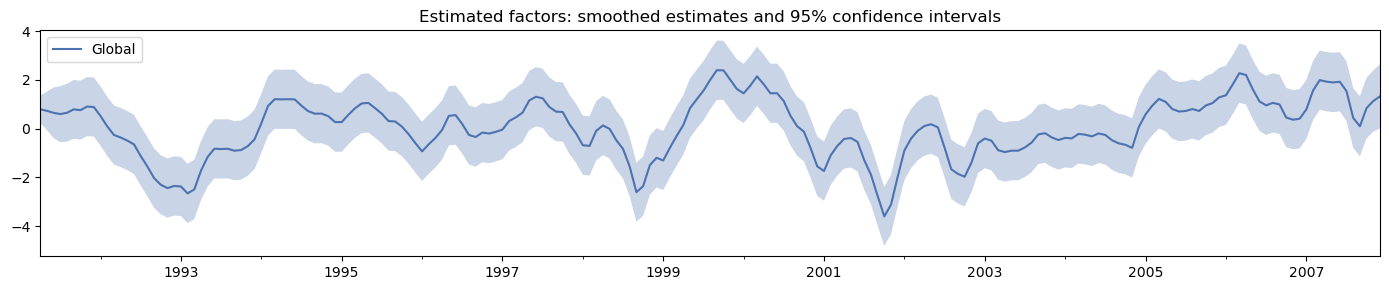

In [20]:
# Get estimates of the Global factors,
# conditional on the full dataset ("smoothed")
factor_names = ['Global']
mean = results.factors.smoothed[factor_names]

# Compute 95% confidence intervals
from scipy.stats import norm
var = pd.concat([results.factors.smoothed_cov.loc[name, name]
                for name in factor_names], axis=1)
std = np.sqrt(var)

crit = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std

with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 3))
    mean.plot(ax=ax)
    
    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)
    
    ax.set(title='Estimated factors: smoothed estimates and 95% confidence intervals')
    fig.tight_layout();

## Explanatory power of the factors

* The global factor is mainly driven by GDP growth along with topics such as Corporate Growth, Crisis, US Politics, Commodity Markets, and Economic Growth.

In [21]:
rsquared = results.get_coefficients_of_determination(method='individual')

top_ten = []
for factor_name in rsquared.columns[:3]:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:10].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by Global      
                                      Variable $R^2$
0                             Corporate Growth  0.53
1                                       Crisis  0.49
2                                  US Politics  0.38
3                            Commodity Markets  0.24
4                              Economic Growth  0.22
5                       Gross Domestic Product  0.21
6                              Problem Solving  0.10
7           Media Coverage of Plans and Rumors  0.09
8                              Policy Measures  0.06
9  Steel Industry Restructuring and Downsizing  0.03

In [22]:
rsquared

,Global
Crisis,0.491073
Corporate Growth,0.528830
Banking,0.013432
Policy Measures,0.062871
Problem Solving,0.097516
US Politics,0.378768
Commodity Markets,0.235007
Economic Growth,0.223089
Media Coverage of Plans and Rumors,0.091648
Steel Industry Restructuring and Downsizing,0.028149


## Plotting R^2

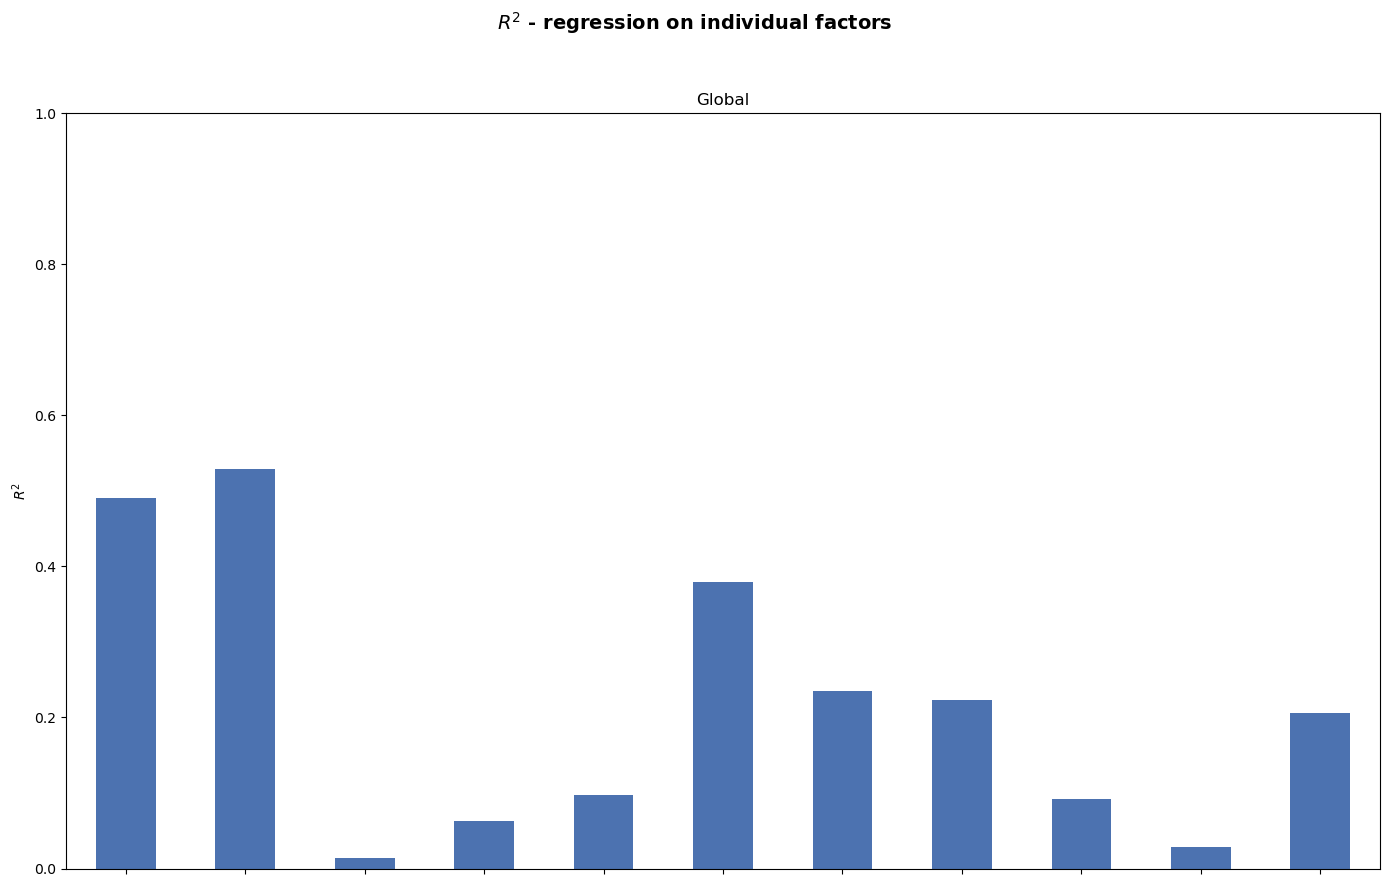

In [23]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(14, 9))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=14, fontweight=600)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);

**Explanatory value of all factors to a given variable**

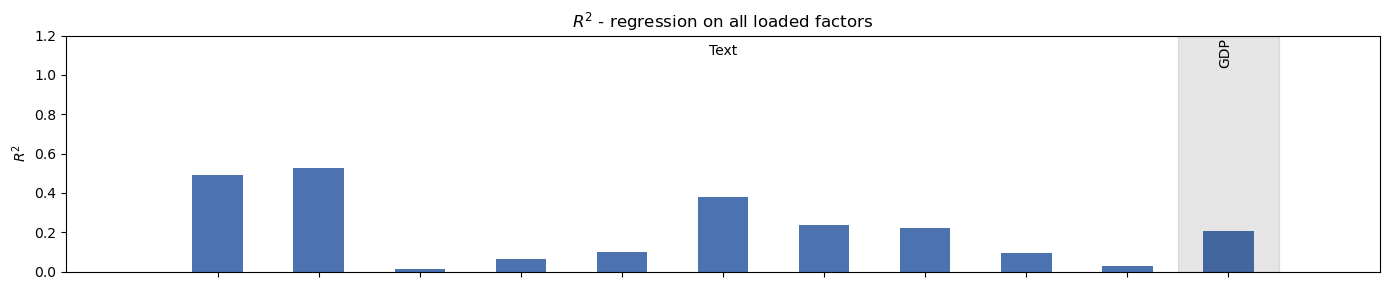

In [24]:
group_counts = defn_combined[['Description', 'Group']]
group_counts = group_counts[group_counts['Description'].isin(dta['2008-01-01'].combined.columns)]
group_counts = group_counts.groupby('Group', sort=False).count()['Description'].cumsum()

with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='joint', figsize=(14, 3));

    # Add in group labels
    ax = fig.axes[0]
    ax.set_ylim(0, 1.2)
    for i in np.arange(1, len(group_counts), 2):
        start = 0 if i == 0 else group_counts.iloc[i - 1]
        end = group_counts.iloc[i] + 1
        ax.fill_between(np.arange(start, end) - 0.6, 0, 1.2, color='k', alpha=0.1)
    for i in range(len(group_counts)):
        start = 0 if i == 0 else group_counts.iloc[i - 1]
        end = group_counts.iloc[i]
        n = end - start
        text = group_counts.index[i]
        #if len(text) > n:
        #    text = text[:n - 3] + '...'

        ax.annotate(text, (start + n / 2, 1.1), ha='center')

    # Add label for a quarterly variable
    ax.set_xlim(-1.5, model.k_endog + 0.5)
    ax.annotate(q_var, (model.k_endog - 1.1, 1.05), ha='left', rotation=90)
    ax.fill_between(np.arange(model.k_endog-1, model.k_endog+1)-0.5, 0, 1.2, color='k', alpha=0.1)
    
    fig.tight_layout();

## Forecasting

* forecast method -> point forecasts only

In [25]:
# Create point forecasts, 3 steps ahead
point_forecasts = results.forecast(steps=3)

# Print the forecasts for the first 5 observed variables
print(point_forecasts.T.head())

                   2008-01   2008-02   2008-03
Crisis           -0.000762 -0.000799 -0.000769
Corporate Growth  0.000892  0.000705  0.000559
Banking          -0.000906 -0.000408 -0.000206
Policy Measures  -0.000445 -0.000332 -0.000248
Problem Solving  -0.000127 -0.000112 -0.000093


In [26]:
# The date of the final forecast
results.forecast('2008-03').T

,2008-01,2008-02,2008-03
Crisis,-0.000762,-0.000799,-0.000769
Corporate Growth,0.000892,0.000705,0.000559
Banking,-0.000906,-0.000408,-0.000206
Policy Measures,-0.000445,-0.000332,-0.000248
Problem Solving,-0.000127,-0.000112,-0.000093
US Politics,-0.001438,-0.001099,-0.000867
Commodity Markets,0.000809,0.000589,0.000427
Economic Growth,-0.000421,-0.000405,-0.000367
Media Coverage of Plans and Rumors,-0.000439,-0.000284,-0.000196
Steel Industry Restructuring and Downsizing,-0.001298,-0.000830,-0.000550


* get_forecast method gives confidence intervals

In [27]:
# point forecast
results.get_forecast('2008-03').predicted_mean[q_var_description]

2008-01    2.303818
2008-02    2.236309
2008-03    2.362276
Freq: M, Name: Gross Domestic Product, dtype: float64

In [28]:
# lower bound
results.get_forecast('2008-03').conf_int(alpha=0.05)[['lower ' + q_var_description]]

,lower Gross Domestic Product
2008-01,-1.945966
2008-02,-2.052116
2008-03,-1.968877


In [29]:
# upper bound
results.get_forecast('2008-03').conf_int(alpha=0.05)[['upper '+ q_var_description]]

,upper Gross Domestic Product
2008-01,6.553603
2008-02,6.524734
2008-03,6.693429


* predict and get_prediction are more general => in-sample and out-of-sample forecasts

In [30]:
prediction_results = results.get_prediction(start='1991-04', end='2008-03')

In [31]:
prediction_results.predicted_mean[q_var_description]

1991-04    -8.832628
1991-05   -19.672116
1991-06    -2.956282
1991-07    -6.099243
1991-08     6.438851
             ...    
2007-11     2.240140
2007-12     1.822444
2008-01     2.303818
2008-02     2.236309
2008-03     2.362276
Freq: M, Name: Gross Domestic Product, Length: 204, dtype: float64

In [32]:
ci = prediction_results.conf_int(alpha=0.05)

In [33]:
ci[['upper ' + q_var_description]]

,upper Gross Domestic Product
1991-04,-5.363607
1991-05,-17.160272
1991-06,-0.535679
1991-07,-4.259787
1991-08,9.621478
...,...
2007-11,5.831203
2007-12,6.092661
2008-01,6.553603
2008-02,6.524734


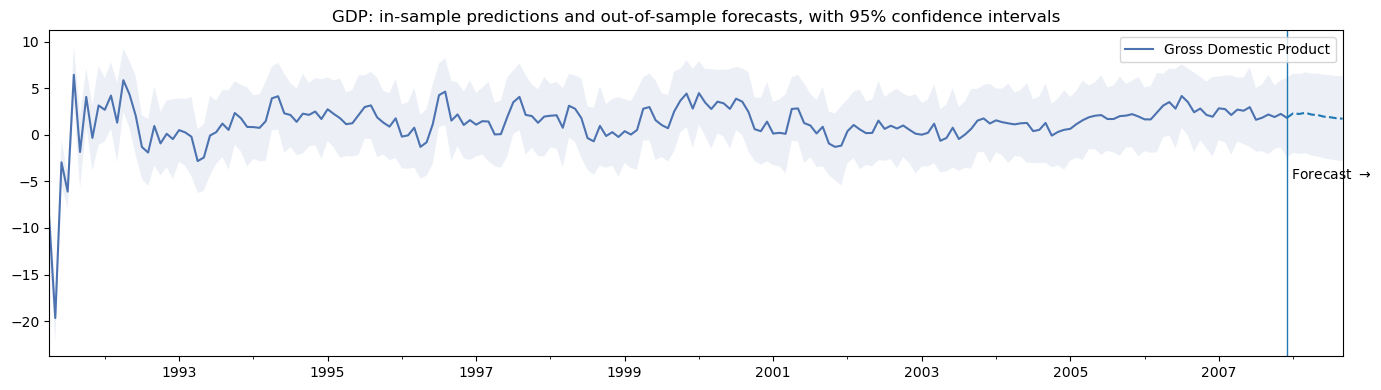

In [34]:
# Create forecasts results objects, through the end of 2008-09
prediction_results = results.get_prediction(start='1991-04', end='2008-09')

variables = ['Gross Domestic Product']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:'2007-12'].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc['2007-12':].plot(ax=ax, linestyle='--',
                                           color=['C0'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines('2007-12', ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', ('2007-12', -4.7))
    ax.set(title=('GDP:'
                  ' in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)
    
    fig.tight_layout()

## GDP forecast

In [35]:
# Compute the point forecasts
#fcast_q = results.forecast('2009-12')[q_var_description].resample('Q').last()
fcast_q = results.get_prediction(start='2007-10', end='2009-12').predicted_mean[q_var_description].resample('Q').last()

C:\Users\mokuneva.UNI-KIEL\AppData\Local\Temp\2\ipykernel_18472\520806084.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  fcast_q = results.get_prediction(start='2007-10', end='2009-12').predicted_mean[q_var_description].resample('Q').last()


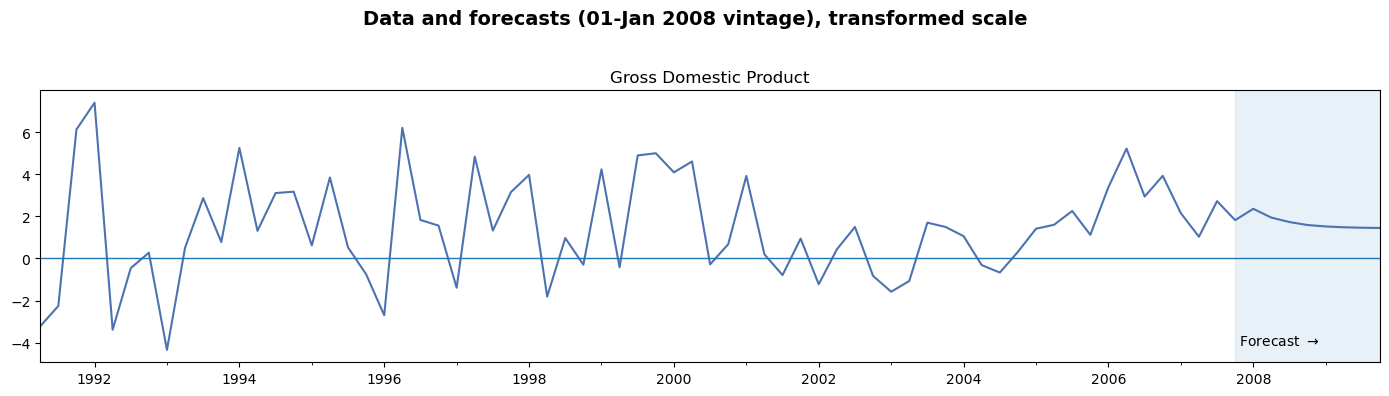

In [36]:
# For more convenient plotting, combine the observed data with the forecasts
plot_q = pd.concat([dta['2008-01-01'].dta_q.loc['1991-04':'2007-09', q_var_description], fcast_q])

with sns.color_palette('deep'):
    fig, axes = plt.subplots(1, figsize=(14, 4))

    # Plot quarterly variable (growth), data and forecasts
    plot_q.plot(ax=axes)
    axes.set(title=q_var_description)
    axes.hlines(0, plot_q.index[0], plot_q.index[-1], linewidth=1)
    
    # Show the forecast period
    ylim = axes.get_ylim()
    axes.fill_between(plot_q.loc['2007-10':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
    axes.annotate(r' Forecast $\rightarrow$',
                         ('2007-10', ylim[0] + 0.1 * ylim[1]))
    axes.set_ylim(ylim)

    # Title
    fig.suptitle('Data and forecasts (01-Jan 2008 vintage), transformed scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);

## Original GDP forecast (2008-01-01 vintage)

In [37]:
# The original point forecasts are monthly
point_forecasts_m = results.forecast('2008-03')[q_var_description]

# Resample to quarterly frequency by taking the value in the last
# month of each quarter
point_forecasts_q = point_forecasts_m.resample('Q').last()

print('Baseline (1st of January 2008) forecast for real GDP growth'
      f' in 2008Q1: {point_forecasts_q["2008Q1"]:.2f}%')

Baseline (1st of January 2008) forecast for real GDP growth in 2008Q1: 2.36%


C:\Users\mokuneva.UNI-KIEL\AppData\Local\Temp\2\ipykernel_18472\646263151.py:6: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  point_forecasts_q = point_forecasts_m.resample('Q').last()


In [38]:
# The original point forecasts are monthly
point_forecasts_m = results.get_prediction(start='2008-03', end='2008-03').predicted_mean[q_var_description]

print('Baseline (1st of January 2008) forecast for real GDP growth'
      f' in 2008Q1: {point_forecasts_q["2008Q1"]:.2f}%')

Baseline (1st of January 2008) forecast for real GDP growth in 2008Q1: 2.36%


## Updated GDP forecast: Jan16 2008 vintage

In [39]:
# Since I will be collecting results for a number of vintages,
# construct a dictionary to hold them, and include the baseline
# results from 01-Jan 2008
vintage_results = {'2008-01-01': results}

# Get the updated monthly and quarterly datasets
start = '1991-04'
updated_endog_m = dta['2008-01-16'].combined.loc[start:, :]
q_var_description = defn_q.loc[q_var, 'Description']
updated_endog_q = dta['2008-01-16'].dta_q.loc[start:, [q_var_description]]

# Get the results for Mid Jan 2008 using `apply`
vintage_results['2008-01-16'] = results.apply(
    updated_endog_m, endog_quarterly=updated_endog_q)

In [40]:
# Print the updated forecast for real GDP growth in 2008Q1
updated_forecasts_q = (
    vintage_results['2008-01-16'].forecast('2008-03')[q_var_description]
                              .resample('Q').last())

print('Mid Jan 2008 forecast for real GDP growth in 2008Q1:'
      f' {updated_forecasts_q["2008Q1"]:.2f}%')

Mid Jan 2008 forecast for real GDP growth in 2008Q1: 2.36%


C:\Users\mokuneva.UNI-KIEL\AppData\Local\Temp\2\ipykernel_18472\4218428434.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  vintage_results['2008-01-16'].forecast('2008-03')[q_var_description]


## Updated GDP forecast: 01Jan2008 - 01Apr 2008 vintages

In [41]:
# Apply our results to the remaining vintages
for vintage in ['2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']:
    # Get updated data for the vintage
    updated_endog_m = dta[vintage].combined.loc[start:, :]
    updated_endog_q = dta[vintage].dta_q.loc[start:, [q_var_description]]

    # Get updated results for for the vintage
    vintage_results[vintage] = results.apply(
        updated_endog_m, endog_quarterly=updated_endog_q)

In [42]:
# Compute forecasts for each vintage
forecasts = {vintage: res.get_prediction(start='2008-03', end='2008-03').predicted_mean[q_var_description].loc['2008-03']
             for vintage, res in vintage_results.items()}
# Convert to a Pandas series with a date index
forecasts = pd.Series(list(forecasts.values()),
                      index=pd.PeriodIndex(forecasts.keys(), freq='D'))
    
# Print our forecast for 2008Q1 real GDP growth across all vintages
for vintage, value in forecasts.items():
    print(f'{vintage} forecast for real GDP growth in 2008Q1:'
          f' {value:.2f}%')

2008-01-01 forecast for real GDP growth in 2008Q1: 2.36%
2008-01-16 forecast for real GDP growth in 2008Q1: 2.36%
2008-02-01 forecast for real GDP growth in 2008Q1: 1.84%
2008-02-16 forecast for real GDP growth in 2008Q1: 1.82%
2008-03-01 forecast for real GDP growth in 2008Q1: 1.63%
2008-03-16 forecast for real GDP growth in 2008Q1: 1.63%
2008-04-01 forecast for real GDP growth in 2008Q1: 1.63%


## News

In [43]:
# Compute the news and impacts on the real GDP growth forecast
# for 2008Q1, between 2008-01-01 and 2008-01-16 vintages
news = vintage_results['2008-01-16'].news(
    vintage_results['2008-01-01'], impact_date='2008-03',
    impacted_variable=q_var_description,
    comparison_type='previous')

# The `summary` method summarizes all updates. Here I am not
# showing it, to save space.
news.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      News                                     
===============================================================================
Model:                DynamicFactorMQ   Original sample:                1991-04
Date:                Tue, 20 May 2025                                 - 2007-12
Time:                        10:58:04   Update through:                 2007-12
                                        # of revisions:                       0
                                        # of new datapoints:                  0
                                                                        Impacts                                                                        
=======================================================================================================================================================
impact date impacted variable estimate (prev) impact of news estimate (new)
---------------------------------------------------------------------------
=======================================================================================================================================================
"""

In [44]:
# I can re-arrange the `details_by_impact` table to show the new
# observations with the top ten impacts (in absolute value)
details = news.details_by_impact
details.index = details.index.droplevel(['impact date', 'impacted variable'])
details['absolute impact'] = np.abs(details['impact'])
details = (details.sort_values('absolute impact', ascending=False)
                  .drop('absolute impact', axis=1))
details.iloc[:10].round(2)

,,observed,forecast (prev),news,weight,impact
update date,updated variable,,,,,


**All vintages**

In [45]:
news_results = {}
vintages = ['2008-01-01', '2008-01-16', '2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']
impact_date = '2008-03'

for i in range(1, len(vintages)):
    vintage = vintages[i]
    prev_vintage = vintages[i - 1]

    # Notice that to get the "incremental" news, we are computing
    # the news relative to the previous vintage and not to the baseline
    # (2008-01-01) vintage
    news_results[vintage] = vintage_results[vintage].news(
        vintage_results[prev_vintage],
        impact_date=impact_date,
        impacted_variable=q_var_description,
        comparison_type='previous')

In [46]:
news_results['2008-04-01'].details_by_impact

observed  \
impact date impacted variable      update date updated variable                                        
2008-03     Gross Domestic Product 2008-03     Banking                                     -0.000901   
                                               Commodity Markets                            0.000808   
                                               Corporate Growth                             0.001009   
                                               Crisis                                       0.000715   
                                               Economic Growth                             -0.002309   
                                               Media Coverage of Plans and Rumors          -0.000008   
                                               Policy Measures                             -0.001593   
                                               Problem Solving                             -0.000498   
                                               Steel Industry Restructuring and Downsizing -0.001069   
                                               US Politics                                  0.001037   

                                                                                            forecast (prev)  \
impact date impacted variable      update date updated variable                                               
2008-03     Gross Domestic Product 2008-03     Banking                                            -0.000142   
                                               Commodity Markets                                   0.000564   
                                               Corporate Growth                                    0.000498   
                                               Crisis                                              0.002558   
                                               Economic Growth                                     0.000164   
                                               Media Coverage of Plans and Rumors                  0.000163   
                                               Policy Measures                                    -0.000682   
                                               Problem Solving                                    -0.000048   
                                               Steel Industry Restructuring and Downsizing         0.000453   
                                               US Politics                                         0.002149   

                                                                                                news  \
impact date impacted variable      update date updated variable                                        
2008-03     Gross Domestic Product 2008-03     Banking                                     -0.000759   
                                               Commodity Markets                            0.000244   
                                               Corporate Growth                             0.000511   
                                               Crisis                                      -0.001843   
                                               Economic Growth                             -0.002473   
                                               Media Coverage of Plans and Rumors          -0.000172   
                                               Policy Measures                             -0.000911   
                                               Problem Solving                             -0.000451   
                                               Steel Industry Restructuring and Downsizing -0.001523   
                                               US Politics                                 -0.001111   

                                                                                               weight  \
impact date impacted variable      update date updated variable                                         
2008-03     Gross Domestic Product 2008-03     Bank

## Impacts by group

In [47]:
group_impacts = {'2008-01-01': None}

for vintage, news in news_results.items():
    # Start from the details by impact table
    details_by_impact = (
        news.details_by_impact.reset_index()
            .drop(['impact date', 'impacted variable'], axis=1))
    
    # Merge with the groups dataset, so that we can identify
    # which group each individual impact belongs to
    impacts = (pd.merge(details_by_impact, groups, how='left',
                        left_on='updated variable', right_on='Description')
                 .drop('Description', axis=1)
                 .set_index(['update date', 'updated variable']))

    # Compute impacts by group, summing across the individual impacts
    group_impacts[vintage] = impacts.groupby('Group').sum()['impact']

# Add in a row of zeros for the baseline forecast
group_impacts['2008-01-01'] = group_impacts['2008-01-16'] * np.nan

# Convert into a Pandas DataFrame, and fill in missing entries
# with zeros (missing entries happen when there were no updates
# for a given group in a given vintage)
group_impacts = (
    pd.concat(group_impacts, axis=1)
      .fillna(0)
      .reindex(group_counts.index).T)
group_impacts.index = forecasts.index

# Print the table of impacts from data in each group,
# along with a row with the "Total" impact
#(group_impacts.T
#    .append(group_impacts.sum(axis=1).rename('Total impact on 2020Q2 forecast'))
#    .round(2).iloc[:, 1:])

pd.concat(
    [
        group_impacts.T,
        group_impacts.sum(axis=1).rename('Total impact on 2008Q1 forecast').to_frame().T
    ],
    axis=0
).round(2).iloc[:, 1:]

,2008-01-16,2008-02-01,2008-02-16,2008-03-01,2008-03-16,2008-04-01
Text,0.0,-0.52,0.0,-0.19,0.0,0.22
Total impact on 2008Q1 forecast,0.0,-0.52,0.0,-0.19,0.0,0.22


**Impacts by group: graphical illustration**

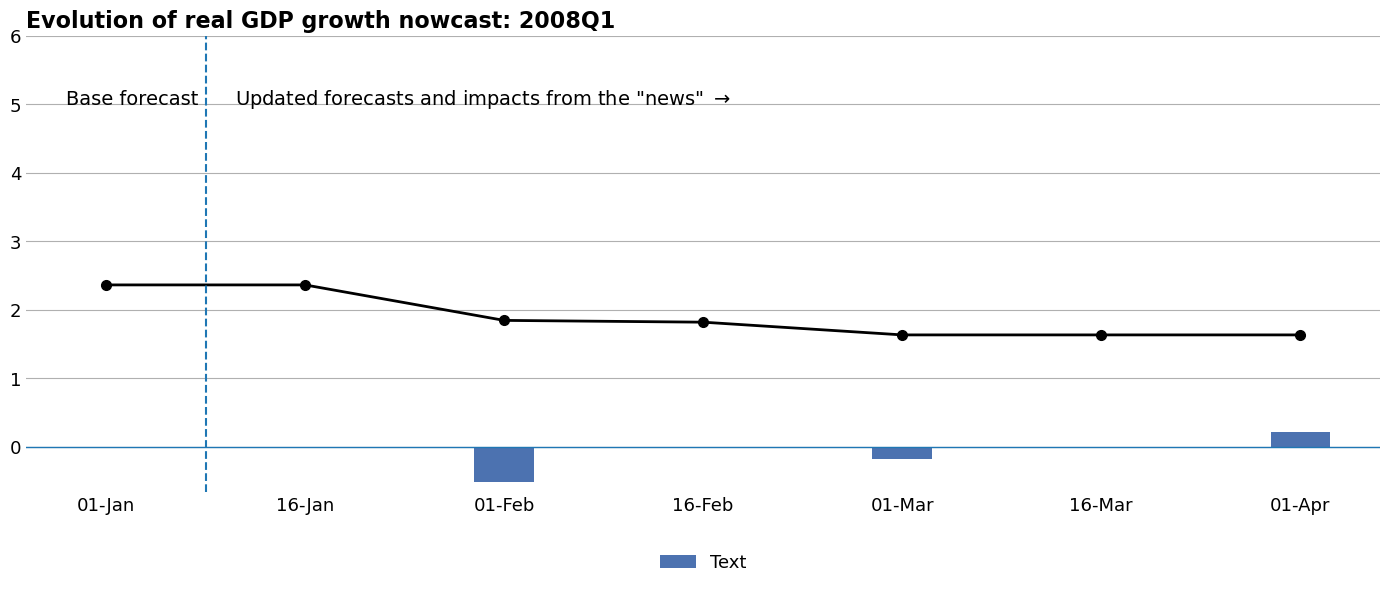

In [48]:
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 6))

    # Stacked bar plot showing the impacts by group
    group_impacts.plot(kind='bar', stacked=True, width=0.3, zorder=2, ax=ax)

    # Line plot showing the forecast for real GDP growth in 2008Q1 for each vintage
    x = np.arange(len(forecasts))
    ax.plot(x, forecasts, marker='o', color='k', markersize=7, linewidth=2)
    ax.hlines(0, -1, len(group_impacts) + 1, linewidth=1)

    # x-ticks
    labels = group_impacts.index.strftime('%d-%b')
    ax.xaxis.set_ticklabels(labels)
    ax.xaxis.set_tick_params(size=0)
    ax.xaxis.set_tick_params(labelrotation='auto', labelsize=13)
    
    # y-ticks
    ax.set_ylim(top=6)
    ax.yaxis.set_tick_params(direction='in', size=0, labelsize=13)
    ax.yaxis.grid(zorder=0)
    
    # title, remove spines
    ax.set_title('Evolution of real GDP growth nowcast: 2008Q1', fontsize=16, fontweight=600, loc='left')
    [ax.spines[spine].set_visible(False)
     for spine in ['top', 'left', 'bottom', 'right']]

    # base forecast vs updates
    ylim = ax.get_ylim()
    ax.vlines(0.5, ylim[0], ylim[1] + 5, linestyles='--')
    ax.annotate('Base forecast', (-0.2, 5), fontsize=14)
    ax.annotate(r'Updated forecasts and impacts from the "news" $\rightarrow$', (0.65, 5), fontsize=14)

    # legend
    ax.legend(loc='upper center', ncol=4, fontsize=13, bbox_to_anchor=(0.5, -0.1), frameon=False)

    fig.tight_layout()